In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from math import isnan
import datetime
from datetime import datetime
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, log_loss
from sklearn.naive_bayes import GaussianNB
%matplotlib inline


 ### Функции
 

In [2]:
def calc_metrcis(X_test,y_test,clf):
    preds = clf.predict(X_test)
    probas = clf.predict_proba(X_test)
    metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
    metrics['f1-score'] = f1_score(y_test, preds)
    metrics['precision'] = precision_score(y_test, preds)
    metrics['recall'] = recall_score(y_test, preds)
    metrics['ROC-AUC'] = roc_auc_score(y_test,probas[:,1])
    metrics['log_loss'] = log_loss(y_test,probas)
    return metrics

In [3]:
def draw_roc_auc(X_test,y_test,clf):
    fpr, tpr, thresholds = get_roc_curve(model=clf, 
              data=Pool(X_test,y_test), 
              thread_count=4, 
              plot=False)
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(fpr,fpr,'--')
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, label=f'ROC-AUC: {roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]):.3f}')
    plt.grid(True)
    plt.show()

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
def q_9(x):
    return np.quantile(x, 0.9) 
def prepare_dataframe(folder,course_id,subject=None):
    
    """
    возвращает таблицу с колонками: element_progress_id, hours_diff, user_id, module_is_achieved, 
                                    size_of_answer, size_of_review, rewiew_time, course_element_id
                                    id from solution_log
    """
    if subject is None:
        path = f'{folder}/{course_id}/'
    else:
        path = f'{folder}/{subject}/{course_id}/'
    try:
        solution_log = pd.read_csv(path+'solution_log.csv')
    except:
        raise Exception(f'No such file or directory',path,'solution_log.csv')
    
    
    solution_log['size_of_answer'] = solution_log['users_answer'].apply(lambda x: len(str(x)))
    solution_log['size_of_review'] = solution_log['review'].apply(lambda x: len(str(x)))

    solution_log = solution_log.dropna(subset=['review_time'])
    solution_log = solution_log.reset_index(drop=True)
    
    ###
    difference = []
    for i in range(len(solution_log['review_time'])):
        a = datetime.strptime(magic(solution_log['submission_time'][i]), '%Y %m %d %H:%M:%S')
        b = datetime.strptime(magic(solution_log['review_time'][i]), '%Y %m %d %H:%M:%S')
        difference.append(b - a)
    solution_log['time_of_expectation'] = difference
    solution_log = solution_log.drop(columns=['submission_time'])
    ###
    
    solution_log['hours_diff']=solution_log['time_of_expectation'].apply(lambda x: x.days*24+x.seconds//3600)
    pre_df = solution_log[['element_progress_id','hours_diff', 'size_of_answer', 'size_of_review', 'tries_count', 'review_time']]
    pre_df['id_from_sl'] = solution_log['id']
    pre_df['id']=pre_df['element_progress_id'].astype(int)
    ##pre_df = pre_df.drop(columns=['element_progress_id'])
    try:
        user_element_progress = pd.read_csv(path+'user_element_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_element_progress.csv')
    user_element_progress['id'] = user_element_progress['id'].astype(int)
    user_element_progress.reset_index(drop=True)
    user_element_progress = user_element_progress[['id','user_id', 'course_element_id']]
    
    try:
        user_module_progress = pd.read_csv(path+'user_module_progress.csv')
    except:
        raise Exception(f'No such file or directory',path,'user_module_progress.csv')
    user_module_progress['is_achieved'] = user_module_progress['is_achieved'].fillna(False).astype(int)
    user_module_progress = user_module_progress[['user_id','course_module_id','is_achieved']]
    
    df = pre_df.merge(user_element_progress).merge(user_module_progress, on='user_id')
    return df
def magic(date):
    date = date[:4]+' '+date[5:7]+' '+date[8:]       
    return date[:18]

In [6]:

def me_grid_search(grid,model,df,test_size = 0.2, cv=5, plot=True):
    X = df.drop(columns=['user_id','is_achieved_max'])
    y = df['is_achieved_max'].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=test_size)
    model.grid_search(param_grid=grid,X=X_train,y=y_train, search_by_train_test_split=False, cv=cv, plot=plot,verbose=False)
    display(model.get_feature_importance(prettified=True).head(10))
    calc_metrcis(X_test,y_test, model)
    draw_roc_auc(X_test,y_test, model)
    return metrics, model

## Новые + первоначальные

In [79]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(folder='courses_with_manual_check',subject = s[1],course_id = c)
            for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
            df=df.append(tmp_df, ignore_index=True)
new_coursers_id = [370,67,71,76,84,226,231,233,251,252,259,307,318]
for ID in new_coursers_id:
    tmp_df = prepare_dataframe(folder='new_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
df = df.sort_values(by = ['user_id', 'review_time'])
df 

,element_progress_id,hours_diff,size_of_answer,size_of_review,tries_count,review_time,id_from_sl,id,user_id,course_element_id,course_module_id,is_achieved
17500,64815057,124,90,34,1,2020-10-28 00:14:03.228184,19424129,64815057,100119700110016452,9369,2610,0
17498,64815054,157,90,34,1,2020-10-29 08:23:38.175426,19424077,64815054,100119700110016452,9366,2610,0
17499,64815053,168,90,362,1,2020-10-29 20:11:57.338260,19424055,64815053,100119700110016452,9324,2610,0
17501,67336056,40,90,34,1,2020-11-07 13:11:25.638969,20003446,67336056,100119700110016452,9576,2610,0
17504,67919957,24,90,286,1,2020-11-10 19:23:48.168905,20147784,67919957,100119700110016452,9603,2610,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1389,93663732,41,2704,34,1,2021-05-20 07:08:06.808021,27882413,93663732,100120100111069319,3139,3454,1
1410,93663731,43,5464,34,1,2021-05-20 08:42:02.612156,27881925,93663731,100120100111069319,4953,3454,1
1404,93663735,39,2675,34,1,2021-05-24 08:48:10.425462,28072480,93663735,100120100111069319,4948,3454,1
1398,93663733,20,90,34,1,2021-05-27 14:20:00.910940,28301677,93663733,100120100111069319,4100,3454,1


In [80]:

q_9.__name__ = '0.9 quantile'
df1 = df.groupby(['user_id','course_module_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df1.columns = ['_'.join(col) for col in df1.columns]
df1.reset_index(inplace=True)
df['less_48'] = df['hours_diff']<48
gdf = df.groupby('user_id').agg({'less_48':'sum','id_from_sl':'count'})
gdf['in_df'] = gdf['less_48']/gdf['id_from_sl'] >= 0.9
valid_indices = gdf[gdf['in_df']].index
df_for_train_new_actual = df1[df1.user_id.isin(valid_indices.values)]

In [81]:
df_for_train_new_actual[df_for_train_new_actual['size_of_answer_std'].isna()]

,user_id,course_module_id,hours_diff_mean,hours_diff_0.9 quantile,hours_diff_median,hours_diff_max,hours_diff_std,hours_diff_min,size_of_answer_mean,size_of_answer_std,size_of_review_mean,size_of_review_std,is_achieved_max
14,100119920110029719,1427,1.0,1.0,1.0,1,NaN,1,133.0,NaN,310.0,NaN,0
15,100119930111128631,2610,45.0,45.0,45.0,45,NaN,45,116.0,NaN,95.0,NaN,0
18,100119970110112023,4443,0.0,0.0,0.0,0,NaN,0,66.0,NaN,34.0,NaN,0
45,100120030110755270,2715,4.0,4.0,4.0,4,NaN,4,90.0,NaN,34.0,NaN,0
89,100120040110045553,2715,24.0,24.0,24.0,24,NaN,24,90.0,NaN,1357.0,NaN,0
102,100120040110088198,2715,1.0,1.0,1.0,1,NaN,1,1735.0,NaN,34.0,NaN,0
118,100120040110279406,958,42.0,42.0,42.0,42,NaN,42,90.0,NaN,85.0,NaN,0
130,100120040110598026,1457,18.0,18.0,18.0,18,NaN,18,134.0,NaN,941.0,NaN,0
180,100120050110009960,4037,5.0,5.0,5.0,5,NaN,5,90.0,NaN,197.0,NaN,0
184,100120050110011454,2511,10.0,10.0,10.0,10,NaN,10,134.0,NaN,1128.0,NaN,0


In [82]:
df_for_train_new_actual.dropna(inplace=True)
df_for_train_new_actual['is_achieved_max'].sum()/df_for_train_new_actual.shape[0]

0.38686131386861317

In [83]:
X = df_for_train_new_actual.drop(columns=['user_id','course_module_id','is_achieved_max'])
y = df_for_train_new_actual['is_achieved_max'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [84]:
preds = np.ones(X_test.shape[0])
probas = np.ones(X_test.shape[0])
constant_metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
constant_metrics['f1-score'] = f1_score(y_test, preds)
constant_metrics['precision'] = precision_score(y_test, preds)
constant_metrics['recall'] = recall_score(y_test, preds)
constant_metrics['ROC-AUC'] = roc_auc_score(y_test,probas)
constant_metrics['log_loss'] = log_loss(y_test,probas)
constant_metrics 

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.54386,0.373494,1.0,0.5,21.639252


In [126]:
clf = RandomForestClassifier(190, random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=190, random_state=42)

In [127]:
rf_metrcis = calc_metrcis(X_test,y_test,clf)
rf_metrcis

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.84375,0.818182,0.870968,0.895471,0.456469


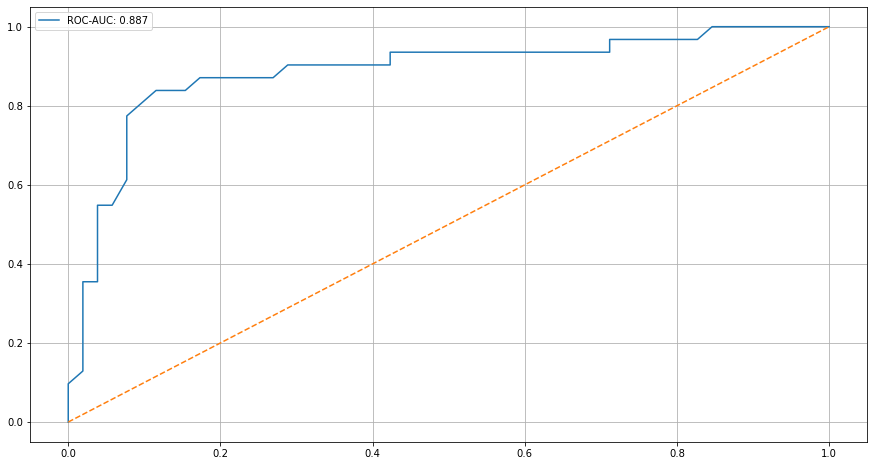

In [87]:
y_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr,label=f'ROC-AUC: {roc_auc_score(y_test, y_proba[:,1]):.3f}')
plt.plot(fpr, fpr, '--')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
g_clf = GaussianNB()
g_clf.fit(X_train,y_train)

GaussianNB()

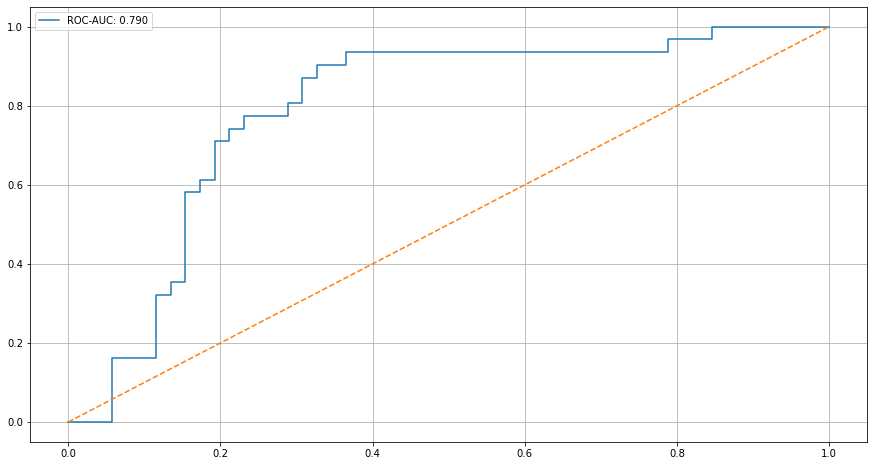

In [48]:
y_proba = g_clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr,label=f'ROC-AUC: {roc_auc_score(y_test, y_proba[:,1]):.3f}')
plt.plot(fpr, fpr, '--')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
gb_metrics = calc_metrcis(X_test,y_test,g_clf)
gb_metrics

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.707317,0.568627,0.935484,0.790323,1.651522


In [97]:
grid = {'l2_leaf_reg':[3,5,7,9,15,2,12],
        'depth':[3,4,5,6,7,8,9],
        'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.85]
}

In [103]:
cat_classifier = CatBoostClassifier(random_seed=42,
                                custom_metric=['Precision','Recall'],
                                eval_metric='F1',
                                 early_stopping_rounds=150,
                                 logging_level='Silent')


In [104]:
cat_classifier.grid_search(grid,X_train,y_train,plot=True,cv=4,verbose=False,search_by_train_test_split=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'params': {'depth': 3, 'l2_leaf_reg': 15, 'learning_rate': 0.85},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [101]:
grid_metrics = calc_metrcis(X_test, y_test, cat_classifier)
grid_metrics

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.677966,0.714286,0.645161,0.815136,0.719355


In [137]:
default_cat = CatBoostClassifier(random_seed=42,
                                iterations=1500, 
                                custom_metric=['F1','Precision','Recall'],
                                 early_stopping_rounds=250,)
                                 #eval_metric='F1')
default_cat.fit(X_train,y_train,eval_set=(X_test,y_test),logging_level='Silent',plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

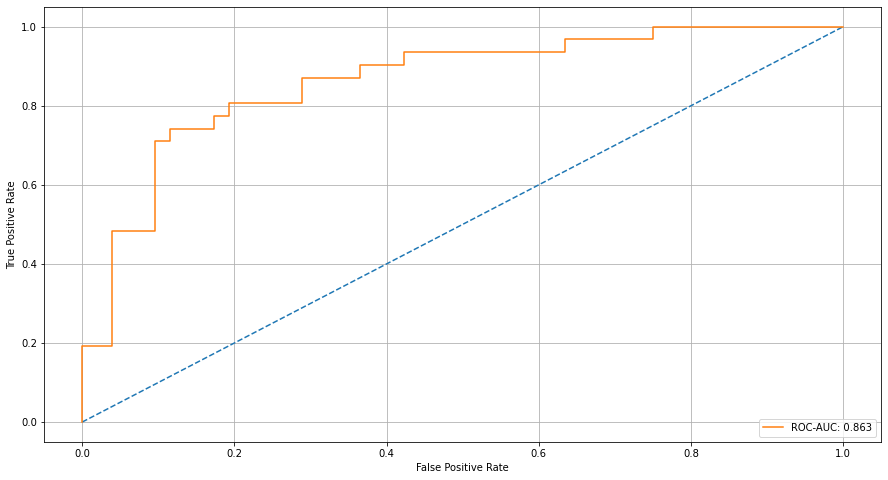

In [55]:
draw_roc_auc(X_test,y_test,default_cat)

In [56]:
default_cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hours_diff_max,15.919241
1,hours_diff_std,13.610198
2,hours_diff_mean,11.257935
3,size_of_review_std,10.841809
4,size_of_review_mean,10.802921
5,size_of_answer_mean,9.805284
6,hours_diff_0.9 quantile,9.173319
7,hours_diff_min,7.544134
8,size_of_answer_std,5.669853
9,hours_diff_median,5.375307


In [57]:
default_cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 75,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'custom_metric': ['Precision', 'Recall'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Loglo

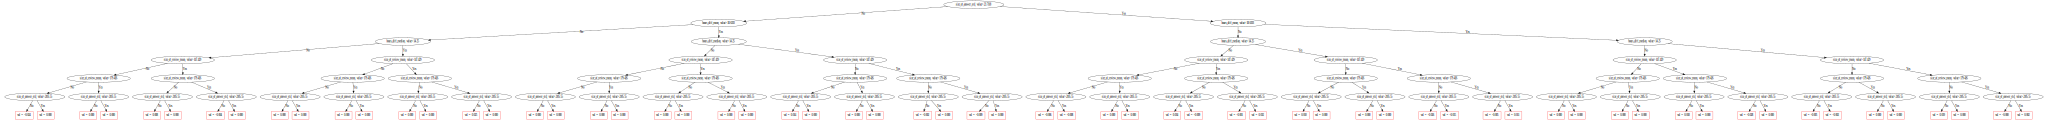

In [58]:
import graphviz
pool = Pool(X, y, feature_names=list(X.columns))
default_cat.plot_tree(322, pool)

In [138]:
default_cat_metrics = calc_metrcis(X_test, y_test, default_cat)
default_cat_metrics

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.75,0.727273,0.774194,0.875931,0.418297


In [105]:
default_cat.save_model('cat_classifier.pkl')

In [128]:
total_not_all = pd.concat([constant_metrics,gb_metrics, rf_metrcis, default_cat_metrics],ignore_index=True)
total_not_all = total_not_all.rename({0:'Constant',1:'GaussianNB',2:'Random Forest',3:'CatBoost'}, axis='index')

In [64]:
subjects = ['math','physics','linguo']
coursers = [['293','294','295'], ['345','346'],['267','268']]
df = pd.DataFrame()
for s in enumerate(subjects):
        for c in coursers[s[0]]:
            tmp_df = prepare_dataframe(folder='courses_with_manual_check',subject = s[1],course_id = c)
            for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
            df=df.append(tmp_df, ignore_index=True)
new_coursers_id = [370,67,71,76,84,226,231,233,251,252,259,307,318]
for ID in new_coursers_id:
    tmp_df = prepare_dataframe(folder='new_courses',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
old_courses = [7,6,23,24,25,26,27,28,29,30,31,32,33,36,40,41,42,45,48,49,50,52,53,54,60]
for ID in old_courses:
    tmp_df = prepare_dataframe(folder='old_courses_with_manual_check',course_id = str(ID))
    for i in tmp_df['user_id']:
                try:
                    if i in df['user_id']:
                        print('Alarm')
                except:
                    pass
    df=df.append(tmp_df, ignore_index=True)
df = df.sort_values(by = ['user_id', 'review_time'])
df2 = df.groupby(['user_id','course_module_id']).agg({'hours_diff':['mean',q_9,'median','max','std','min'], 
                         'size_of_answer':['mean','std'], 
                         'size_of_review':['mean','std'],
                         'is_achieved':'max'})
df2.columns = ['_'.join(col) for col in df2.columns]
df2.reset_index(inplace=True)
df['less_48'] = df['hours_diff']<48
gdf = df.groupby('user_id').agg({'less_48':'sum','id_from_sl':'count'})
gdf['in_df'] = gdf['less_48']/gdf['id_from_sl'] >= 0.9
valid_indices = gdf[gdf['in_df']].index
df_for_train_all = df2[df2.user_id.isin(valid_indices.values)]

In [65]:
df_for_train_all.dropna(inplace=True)

In [66]:
X = df_for_train_all.drop(columns=['user_id','course_module_id','is_achieved_max'])
y = df_for_train_all['is_achieved_max'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [67]:
y.sum()/len(y)

0.3356353591160221

In [68]:
preds = np.ones(X_test.shape[0])
probas = np.ones(X_test.shape[0])
constant_metrics = pd.DataFrame(columns=['f1-score','precision','recall','ROC-AUC'],index=[0])
constant_metrics['f1-score'] = f1_score(y_test, preds)
constant_metrics['precision'] = precision_score(y_test, preds)
constant_metrics['recall'] = recall_score(y_test, preds)
constant_metrics['ROC-AUC'] = roc_auc_score(y_test,probas)
constant_metrics['log_loss'] = log_loss(y_test,probas)
constant_metrics 

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.481675,0.317241,1.0,0.5,23.582193


In [69]:
clf = RandomForestClassifier(200, random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [70]:
rf_metrcis = calc_metrcis(X_test,y_test,clf)
rf_metrcis

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.5,0.552632,0.456522,0.780742,0.512465


In [71]:
g_clf = GaussianNB()
g_clf.fit(X_train,y_train)

GaussianNB()

In [72]:
gb_metrics = calc_metrcis(X_test,y_test,g_clf)
gb_metrics

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.549296,0.40625,0.847826,0.698726,1.427801


In [73]:
default_cat = CatBoostClassifier(random_seed=42,
                                custom_metric=['Precision','Recall'],
                                 early_stopping_rounds=100)
default_cat.fit(X_train,y_train,eval_set=(X_test,y_test),logging_level='Silent',plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

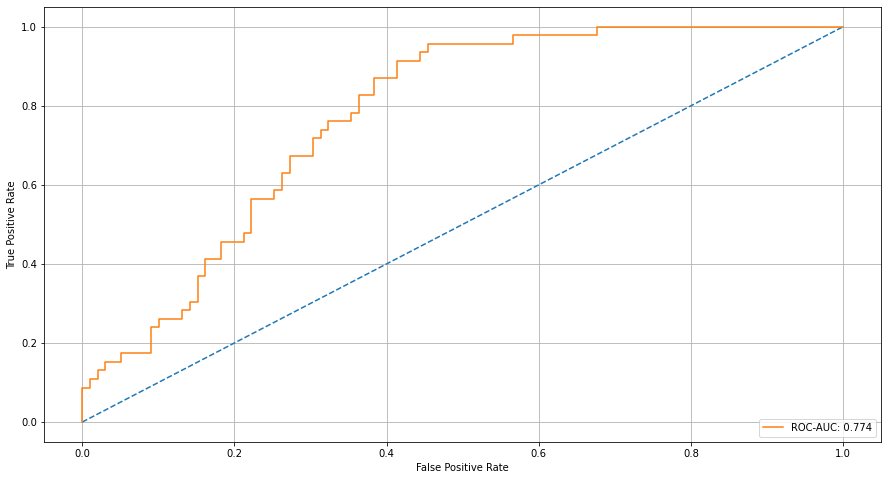

In [74]:
draw_roc_auc(X_test,y_test,default_cat)

In [75]:
default_cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hours_diff_max,16.777153
1,size_of_review_mean,15.798936
2,hours_diff_min,13.224586
3,hours_diff_mean,9.858154
4,size_of_answer_mean,9.209873
5,hours_diff_std,8.440547
6,size_of_answer_std,7.553087
7,hours_diff_0.9 quantile,7.468044
8,size_of_review_std,7.066899
9,hours_diff_median,4.602720


In [76]:
default_cat_metrics = calc_metrcis(X_test, y_test, default_cat)
default_cat_metrics

,f1-score,precision,recall,ROC-AUC,log_loss
0,0.488889,0.5,0.478261,0.774264,0.511626


In [77]:
total = pd.concat([constant_metrics,gb_metrics, rf_metrcis, default_cat_metrics],ignore_index=True)
total = total.rename({0:'Constant',1:'GaussianNB',2:'Random Forest',3:'CatBoost'}, axis='index')
total 

,f1-score,precision,recall,ROC-AUC,log_loss
Constant,0.481675,0.317241,1.000000,0.500000,23.582193
GaussianNB,0.549296,0.406250,0.847826,0.698726,1.427801
Random Forest,0.500000,0.552632,0.456522,0.780742,0.512465
CatBoost,0.488889,0.500000,0.478261,0.774264,0.511626


In [129]:
pd.concat([total,total_not_all],keys=('all data','new data')).swaplevel(0,1).sort_index()


f1-score  precision    recall   ROC-AUC   log_loss
CatBoost      all data  0.488889   0.500000  0.478261  0.774264   0.511626
              new data  0.806452   0.806452  0.806452  0.863524   0.490895
Constant      all data  0.481675   0.317241  1.000000  0.500000  23.582193
              new data  0.543860   0.373494  1.000000  0.500000  21.639252
GaussianNB    all data  0.549296   0.406250  0.847826  0.698726   1.427801
              new data  0.549296   0.406250  0.847826  0.698726   1.427801
Random Forest all data  0.500000   0.552632  0.456522  0.780742   0.512465
              new data  0.843750   0.818182  0.870968  0.895471   0.456469

In [139]:
default_cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hours_diff_max,16.727729
1,hours_diff_std,14.523267
2,size_of_review_mean,10.834240
3,hours_diff_mean,10.216222
4,size_of_review_std,10.194253
5,size_of_answer_mean,9.785463
6,hours_diff_0.9 quantile,9.519554
7,hours_diff_min,7.387740
8,hours_diff_median,5.462001
9,size_of_answer_std,5.349530


In [140]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

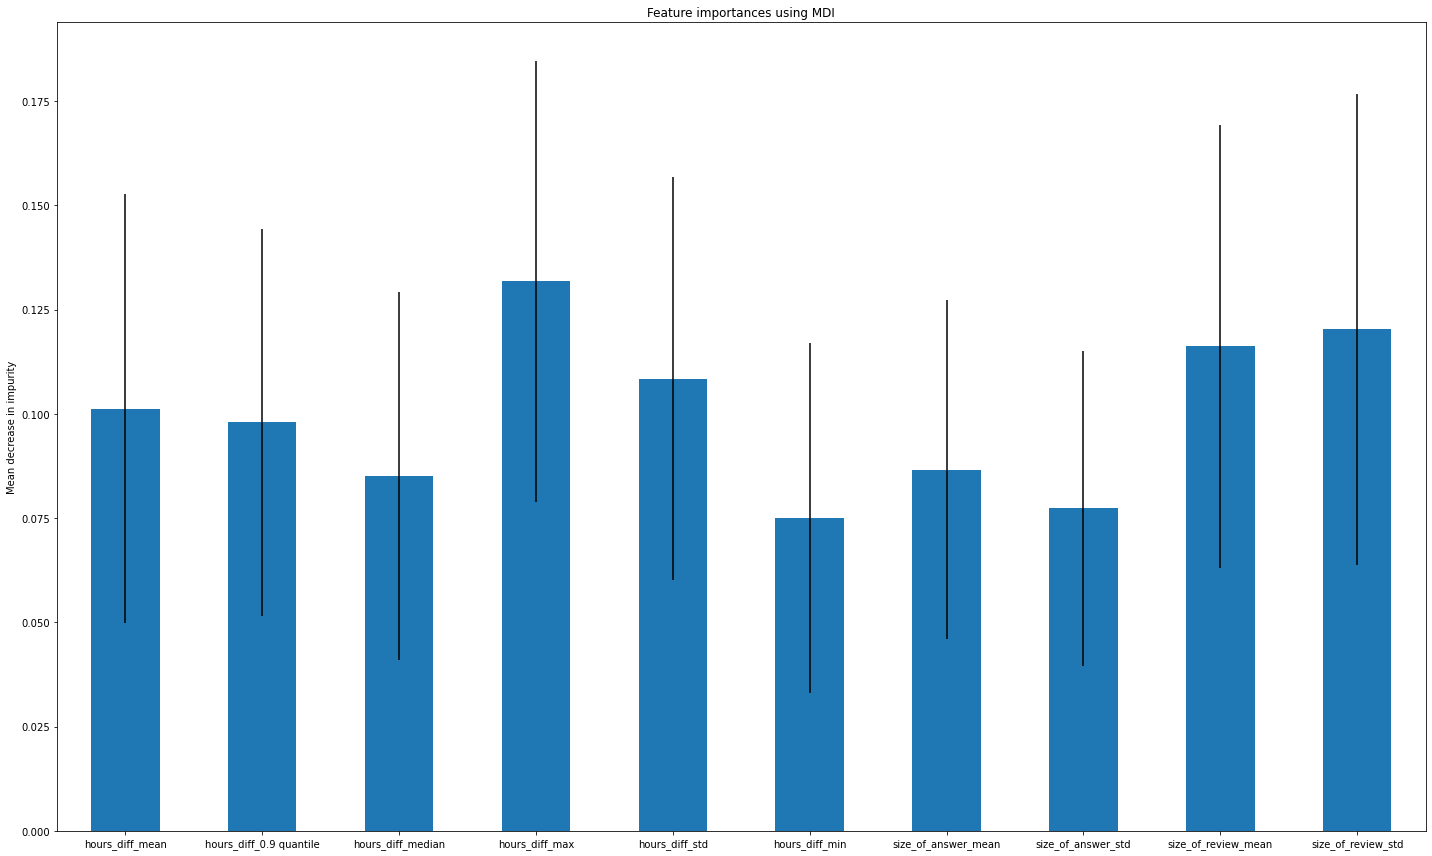

In [146]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(20,12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=0)
fig.tight_layout()